Work through https://machinelearningmastery.com/how-to-predict-room-occupancy-based-on-environmental-factors/ although I deviate in some naming

After completing this tutorial, you will know:

* The Occupancy Detection standard time series classification problem in machine learning.
* How to load and visualize multivariate time series classification data.
* How to develop simple naive and logistic regression models that achieve nearly perfect skill on the problem.

We are using the dataset [Occupancy Detection Data Set, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). This is a binary classification problem which requires that an observation of environmental factors such as temperature and humidity be used to classify whether a room is occupied or unoccupied. *An office room […] was monitored for the following variables: temperature, humidity, light and CO2 levels. A microcontroller was employed to acquire the data. A ZigBee radio was connected to it and was used to transmit the information to a recording station. A digital camera was used to determine if the room was occupied or not. The camera time stamped pictures every minute and these were studied manually to label the data.*

Data is provided with date-time information and six environmental measures taken each minute over multiple days, specifically:

* Temperature in Celsius.
* Relative humidity as a percentage.
* Light measured in lux.
* Carbon dioxide measured in parts per million.
* Humidity ratio, derived from temperature and relative humidity measured in kilograms of water vapor per kilogram of air.
* Occupancy as either 1 for occupied or 0 for not occupied.

The data is available in CSV format in three files, claimed to be a split of data for training, validation and testing.

The three files are as follows:

* datatest.txt (test): From 2015-02-02 14:19:00 to 2015-02-04 10:43:00
* datatraining.txt (train): From 2015-02-04 17:51:00 to 2015-02-10 09:33:00
* datatest2.txt (val): From 2015-02-11 14:48:00 to 2015-02-18 09:19:00

The published paper is https://www.sciencedirect.com/science/article/pii/S0378778815304357

## Data prep

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/occupancy-detection-data-set-uci/datatest.txt
/kaggle/input/occupancy-detection-data-set-uci/datatest2.txt
/kaggle/input/occupancy-detection-data-set-uci/datatraining.txt


In [2]:
test = pd.read_csv('/kaggle/input/occupancy-detection-data-set-uci/datatest.txt', header=0, index_col=1, parse_dates=True, squeeze=True)

In [3]:
test.drop('date', axis=1, inplace=True)

In [4]:
test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [5]:
train = pd.read_csv('/kaggle/input/occupancy-detection-data-set-uci/datatraining.txt', header=0, index_col=1, parse_dates=True, squeeze=True)

In [6]:
train.drop('date', axis=1, inplace=True)

In [7]:
train.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [8]:
validate = pd.read_csv('/kaggle/input/occupancy-detection-data-set-uci/datatest2.txt', header=0, index_col=1, parse_dates=True, squeeze=True)

In [9]:
validate.drop('date', axis=1, inplace=True)

In [10]:
validate.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


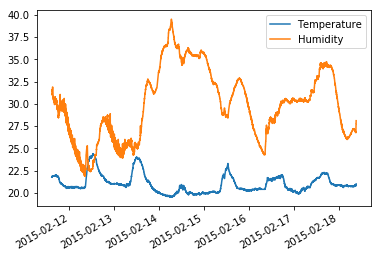

In [11]:
validate[['Temperature', 'Humidity']].plot()

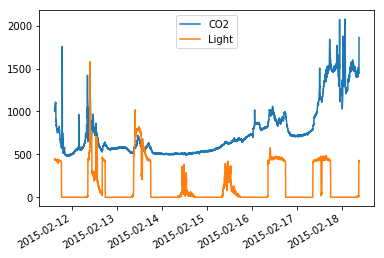

In [12]:
validate[['CO2', 'Light']].plot()

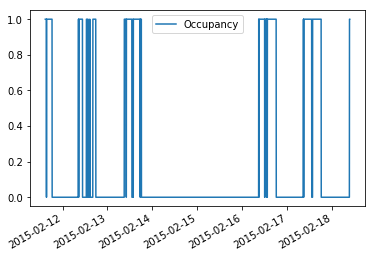

In [13]:
validate[['Occupancy']].plot()

## Concatenated Dataset
We can simplify the dataset by preserving the temporal consistency of the data and concatenating all three sets into a single dataset, dropping the “no” column.

This will allow ad hoc testing of simple direct framings of the problem (in the next section) that can be tested on a temporally consistent way with ad hoc train/test set sizes.

Note: This simplification does not account for the temporal gaps in the data and algorithms that rely on a sequence of observations at prior time steps may require a different organization of the data.

In [14]:
data = pd.concat([test, train, validate])

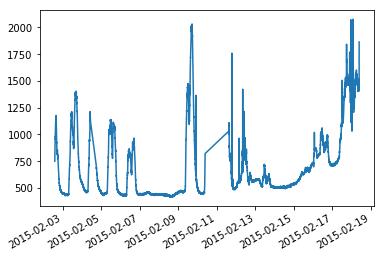

In [15]:
data["CO2"].plot()

## Simple Predictive Models
The simplest formulation of the problem is to predict occupancy based on the environmental conditions at the current time.

I refer to this as a direct model as it does not make use of the observations of the environmental measures at prior time steps. Technically, this is not sequence classification, it is just a straight classification problem where the observations are temporally ordered.

This seems to be the standard formulation of the problem from my skim of the literature, and disappointingly, the papers seem to use the train/validation/test data as labeled on the UCI website.

We will use the combined dataset described in the previous section and evaluate model skill by holding back the last 30% of the data as a test set. For example:

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
values = data.values
# split data into inputs and outputs
X, y = values[:, :-1], values[:, -1]
# split the dataset
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=1)

## Naive Model
A simple model for this formulation of the problem is to predict the most prominent class outcome. This is called the Zero Rule, or the naive prediction algorithm. We will evaluate predicting all 0 (unoccupied) and all 1 (occupied) for each example in the test set and evaluate the approach using the accuracy metric.

In [18]:
# make a naive prediction
def naive_prediction(testX, value):
	return [value for x in range(len(testX))]
 
# evaluate skill of predicting each class value
for value in [0, 1]:
	# forecast
	yhat = naive_prediction(testX, value)
	# evaluate
	score = accuracy_score(testy, yhat)
	# summarize
	print('Naive=%d score=%.3f' % (value, score))

Naive=0 score=0.822
Naive=1 score=0.178


So always predicting unoccupied is 82% accurate on the test set.. For any model to be considered skilful on the problem, it must achieve a skill of 82% or better.

## Logistic Regression
A skim of the literature shows a range of sophisticated neural network models applied on this problem.

To start with, let’s try a simple logistic regression classification algorithm.

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(trainX, trainy)
# predict the test set
yhat = model.predict(testX)
# evaluate model skill
score = accuracy_score(testy, yhat)
print(score)

0.992704280155642


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The skill of the model is about 99% accurate, showing skill over the naive method.

## Feature Selection and Logistic Regression
A closer look at the time series plot shows a clear relationship between the times when the rooms are occupied and peaks in the environmental measures.

This makes sense and explains why this problem is in fact so easy to model.

We can further simplify the model by testing a simple logistic regression model on each environment measure in isolation. The idea is that we don’t need all of the data to predict occupancy; that perhaps just one of the measures is sufficient.

This is the simplest type of feature selection where a model is created and evaluated with each feature in isolation. More advanced methods may consider each subgroup of features.

In [21]:
# basic feature selection
features = [0, 1, 2, 3, 4]
for f in features:
	# split data into inputs and outputs
	X, y = values[:, f].reshape((len(values), 1)), values[:, -1]
	# split the dataset
	trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=1)
	# define the model
	model = LogisticRegression()
	# fit the model on the training set
	model.fit(trainX, trainy)
	# predict the test set
	yhat = model.predict(testX)
	# evaluate model skill
	score = accuracy_score(testy, yhat)
	print('feature=%d, name=%s, score=%.3f' % (f, data.columns[f], score))

feature=0, name=Temperature, score=0.799


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


feature=1, name=Humidity, score=0.822
feature=2, name=Light, score=0.991
feature=3, name=CO2, score=0.763
feature=4, name=HumidityRatio, score=0.822


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We can see that only the “Light” variable is required in order to achieve 99% accuracy on this dataset.

It is very likely that the lab rooms in which the environmental variables were recorded had a light sensor that turned internal lights on when the room was occupied.

Alternately, perhaps the light is recorded during the daylight hours (e.g. sunshine through windows), and the rooms are occupied on each day, or perhaps each week day.

At the very least, the results of this tutorial ask some hard questions about any research papers that use this dataset, as clearly it is not a challenging prediction problem.

In [22]:
## Extensions
This data may still be interesting for further investigation.

Some ideas include:

Perhaps the problem would be more challenging if the light column was removed.
Perhaps the problem can be framed as a true multivariate time series classification where lag observations are used in the model.
Perhaps the clear peaks in the environmental variables can be exploited in the prediction.
I tried each of these models briefly without exciting results.

SyntaxError: invalid syntax (<ipython-input-22-e24eb59a102d>, line 2)

## Extensions
This data may still be interesting for further investigation.

Some ideas include:

Perhaps the problem would be more challenging if the light column was removed.
Perhaps the problem can be framed as a true multivariate time series classification where lag observations are used in the model.
Perhaps the clear peaks in the environmental variables can be exploited in the prediction.
I tried each of these models briefly without exciting results.